# 05 — Executive Summary
Summarize methodology, results, risks, and next steps.

- Objective: predict next-month excess returns, construct portfolios, and backtest OOS.
- Data: yfinance monthly prices; S&P500 proxy (acknowledge survivorship bias).
- Methods: Ridge/LASSO, XGBoost; cross-sectional z-scored features (momentum/vol/beta).
- Portfolio: long-short decile, long-only quintile; 25 bps/trade costs.
- Metrics: Sharpe, drawdown, IC/IR, turnover.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("../data")
DATA.mkdir(parents=True, exist_ok=True)

In [2]:
def sharpe_m(ret: pd.Series):
    ret = pd.to_numeric(ret, errors='coerce').dropna()
    den = ret.std(ddof=1)
    return np.nan if den == 0 or np.isnan(den) else ret.mean()/den

def ann_ret(ret_m: pd.Series, periods_per_yr=12):
    ret_m = pd.to_numeric(ret_m, errors='coerce').dropna()
    if ret_m.empty: return np.nan
    growth = (1+ret_m).prod()
    years = len(ret_m) / periods_per_yr
    return growth**(1/years) - 1 if years > 0 else np.nan

def ann_vol(ret_m: pd.Series, periods_per_yr=12):
    ret_m = pd.to_numeric(ret_m, errors='coerce').dropna()
    return ret_m.std(ddof=1) * np.sqrt(periods_per_yr) if len(ret_m)>1 else np.nan

def max_drawdown(ret_m: pd.Series):
    curve = ret_m.cumsum()
    dd = curve - curve.cummax()
    return dd.min()

def calc_turnover_from_names(names_ser: pd.Series):
    """names_ser is a Series index by date, values are sets of names held that month"""
    if names_ser is None or names_ser.empty: 
        return pd.Series(dtype=float)
    out = []
    prev = set()
    for dt, cur in names_ser.items():
        chg = 0 if not prev else 1 - len(prev & cur)/len(prev | cur)
        out.append((dt, chg))
        prev = cur
    return pd.Series(dict(out)).sort_index()

In [3]:
def load_pack(prefix=""):
    pack = {}
    # scores (predictions by date×ticker)
    f = DATA/(f"scores_walkforward{prefix}.parquet")
    pack["scores"] = pd.read_parquet(f) if f.exists() else pd.DataFrame()

    # IC time series
    f = DATA/(f"ic{prefix}.parquet")
    pack["ic"] = pd.read_parquet(f)["IC"] if f.exists() else pd.Series(dtype=float)

    # long-short monthly net PnL
    f = DATA/(f"long_short_monthly_net{prefix}.parquet")
    pack["net"] = pd.read_parquet(f)["L_S_net"] if f.exists() else pd.Series(dtype=float)

    # optional turnover
    f = DATA/(f"turnover{prefix}.parquet")
    pack["turn"] = pd.read_parquet(f)["turnover"] if f.exists() else pd.Series(dtype=float)

    # optional held names (to recompute turnover if needed)
    f = DATA/(f"held_names{prefix}.parquet")
    pack["names"] = pd.read_parquet(f)["names"] if f.exists() else pd.Series(dtype=object)

    # recompute turnover if missing but we have names
    if (pack["turn"].empty) and (not pack["names"].empty):
        pack["turn"] = calc_turnover_from_names(pack["names"])

    return pack

ridge = load_pack(prefix="")
xgb   = load_pack(prefix="_xgb")

ridge.keys(), len(ridge["net"]), len(xgb["net"])


(dict_keys(['scores', 'ic', 'net', 'turn', 'names']), 87, 93)

In [4]:
def summarize_model(name, pack):
    net = pack["net"].sort_index()
    ic  = pack["ic"].sort_index()
    turn = pack["turn"].reindex(net.index).fillna(0)

    summary = pd.Series({
        "model": name,
        "IC_mean": ic.mean(),
        "IC_std": ic.std(ddof=1),
        "IC_tstat": ic.mean() / (ic.std(ddof=1) / np.sqrt(ic.notna().sum())) if ic.notna().sum()>1 else np.nan,
        "IC_hit": (ic > 0).mean(),
        "LS_mean_m": net.mean(),
        "LS_std_m": net.std(ddof=1),
        "Sharpe_m": sharpe_m(net),
        "Ann_Return": ann_ret(net),
        "Ann_Vol": ann_vol(net),
        "MaxDD": max_drawdown(net),
        "Turnover_m": turn.mean()
    })
    return summary


In [5]:
rows = []
if not ridge["net"].empty: rows.append(summarize_model("Ridge", ridge))
if not xgb["net"].empty:   rows.append(summarize_model("XGB", xgb))

report = pd.DataFrame(rows).set_index("model")
report.round(3)


,IC_mean,IC_std,IC_tstat,IC_hit,LS_mean_m,LS_std_m,Sharpe_m,Ann_Return,Ann_Vol,MaxDD,Turnover_m
model,,,,,,,,,,,
Ridge,-0.015,0.126,-1.081,0.425,0.018,0.102,0.175,0.185,0.354,-0.272,0.518
XGB,-0.008,0.092,-0.821,0.430,0.014,0.085,0.163,0.144,0.293,-0.334,0.580


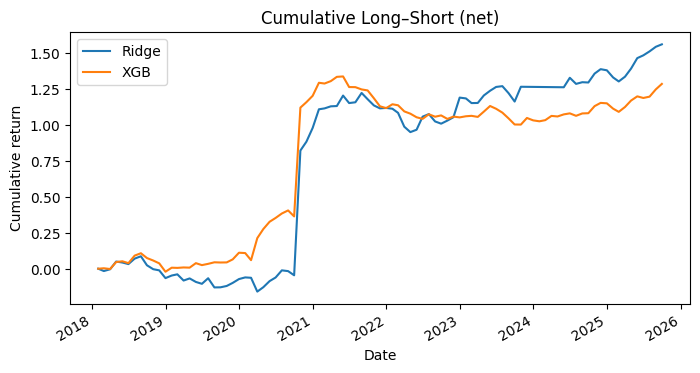

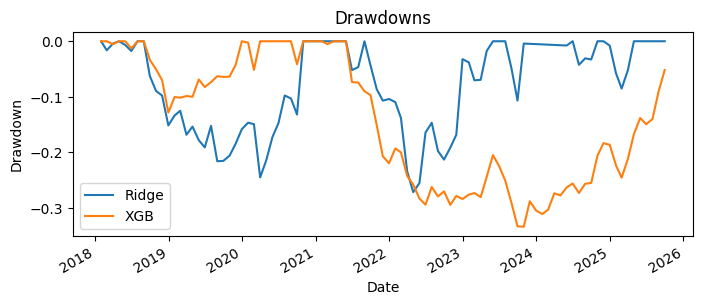

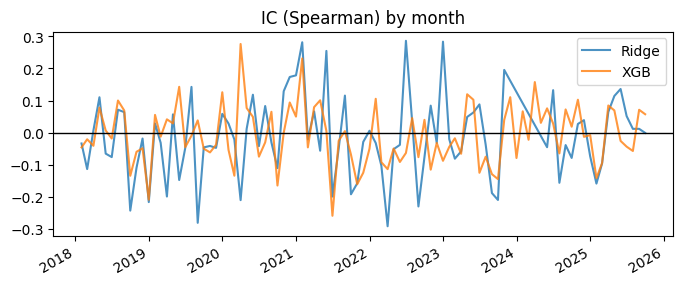

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
if not ridge["net"].empty: ridge["net"].cumsum().plot(ax=ax, label="Ridge")
if not xgb["net"].empty:   xgb["net"].cumsum().plot(ax=ax, label="XGB")
ax.set_title("Cumulative Long–Short (net)")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative return")
ax.legend(); plt.show()

# Drawdowns
def dd_series(net):
    curve = net.cumsum()
    return curve - curve.cummax()

fig, ax = plt.subplots(1,1, figsize=(8,3))
if not ridge["net"].empty: dd_series(ridge["net"]).plot(ax=ax, label="Ridge")
if not xgb["net"].empty:   dd_series(xgb["net"]).plot(ax=ax, label="XGB")
ax.set_title("Drawdowns"); ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
ax.legend(); plt.show()

# IC time series
fig, ax = plt.subplots(1,1, figsize=(8,3))
if not ridge["ic"].empty: ridge["ic"].plot(ax=ax, alpha=.8, label="Ridge")
if not xgb["ic"].empty:   xgb["ic"].plot(ax=ax, alpha=.8, label="XGB")
ax.axhline(0, color="k", lw=1)
ax.set_title("IC (Spearman) by month"); ax.legend(); plt.show()


In [7]:
report_path = DATA/"model_report_summary.parquet"
report.round(6).to_parquet(report_path)
report.round(3)


,IC_mean,IC_std,IC_tstat,IC_hit,LS_mean_m,LS_std_m,Sharpe_m,Ann_Return,Ann_Vol,MaxDD,Turnover_m
model,,,,,,,,,,,
Ridge,-0.015,0.126,-1.081,0.425,0.018,0.102,0.175,0.185,0.354,-0.272,0.518
XGB,-0.008,0.092,-0.821,0.430,0.014,0.085,0.163,0.144,0.293,-0.334,0.580
